In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time

start = time.time()

data_folder = "data"
# article_files = ["articles2019-06-01_" + str(i) + "-" + str(i + 5000) + ".csv" for i in range(0, 100000, 5000)]
# article_files = article_files + ["articles2019-06-01_100000-100755.csv"]

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

def subsetmat(mat, inds):
    ''' Returns subset matrix of symmetric matrix mat, using inds
    '''
    subset = np.zeros((len(inds), len(inds)))
    for i in range(len(inds)):
        for j in range(len(inds)):
            subset[i, j] = mat[inds[i], inds[j]]
    return subset

article_df = pd.read_pickle(os.path.join(data_folder, "article_df_20190601"))

events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
n = [len(article_df.loc[article_df["event"] == event]) for event in events]
print("Event sizes: ", n)

try:
    results_df = pd.read_csv("results_20190601_clusters_temp.csv")
except: 
    results_df = pd.DataFrame(list(zip(events, n)), columns = ["event", "n"])
    results_df["unique25"] = np.nan
    results_df["unique75"] = np.nan
    results_df["n_good"] = np.nan
    results_df["unique25_good"] = np.nan
    results_df["unique75_good"] = np.nan

ac = tc.ArticleComparisons(thresh_jaccard = .5, thresh_same_sent = .9, thresh_same_doc = .25)
print("Setup time: %d seconds" % np.round(time.time() - start))
article_df.head(3)

Event sizes:  [3175, 7333, 3280, 790, 750, 479, 1267, 2399, 269, 464, 187, 543, 580, 272, 1027, 377, 286, 391, 997, 269, 907, 272, 287, 351, 131, 333, 275, 503, 1067, 135, 691, 225, 123, 241, 263, 108, 140, 70, 239, 365, 172, 79, 244, 68, 68, 54, 69, 172, 172, 165]
Setup time: 1 seconds


,id,publisher,scrape_time,on_homepage,url,title,text,fingerprint,event,doc,paywall
0,0,beforeitsnews.com,2019-06-01T04:51:24-04:00,True,https://beforeitsnews.com/v3/christian-news/20...,"47:2-3, 8-",First Option - Responsorial Psalm: Psalms 47:2...,"{'wordCounts': {'2': 1, '713350': 1, '14736': ...",NaN,None,0.0
1,1,thehindu.com,2019-06-01T08:44:25-04:00,True,https://www.thehindu.com/news/cities/Coimbator...,"In Gudalur, meat will come packed in Koova lea...","ePaper \n Just In \n In Gudalur, meat will com...","{'wordCounts': {'80836': 1, '3': 314, '11': 15...",NaN,None,0.0
2,2,cincinnati.com,2019-06-01T15:30:59-04:00,False,https://www.cincinnati.com/story/money/cars/20...,Trump's Mexico tariffs would hurt GM the most ...,FacebookEmail Twitter Google+ LinkedIn Pintere...,"{'wordCounts': {'17655': 1, '1999': 1, '3693':...",1.0,None,0.0


In [15]:
n = 500
sample = random.sample(list(article_df["id"]), n)
start = time.time()
article_dict = dict_by_ids(article_df, sample)
elapsed = round(time.time() - start, 2)
print("Time taken to run cell: %f s (%f s per document)" % (elapsed, elapsed/n))

Time taken to run cell: 6.100000 s (0.012200 s per document)


In [13]:
start = time.time()

for doc in sample:
    bow_sents = article_df.loc[doc, "doc"].get_bow_sentences()
    bow_sent_lens = [len(s) for s in bow_sents]
    
elapsed = time.time() - start
print("Time taken to run cell: %f s" % (elapsed))

Time taken to run cell: 0.082001 s


In [14]:
start = time.time()

for doc in sample:
    bow_sent_lens = article_df.loc[doc, "doc"].bow_sent_lens

elapsed = time.time() - start
print("Time taken to run cell: %f s" % (elapsed))

Time taken to run cell: 0.066000 s


In [18]:
i = 30
sample = np.array(article_df.loc[article_df["event"] == events[i], "id"])
article_dict = dict_by_ids(article_df, sample)
good_inds = [i for i in range(len(sample)) if article_df.loc[sample[i], "paywall"] == 0]
results_df.loc[i, "n_good"] = len(good_inds)
print(len(good_inds), len(sample))

615 691


In [36]:
clustering = ac.cluster_articles(article_dict, plot = False)
results_df.loc[i, "unique25"] = ac.prop_unique_clusters(thresh_same_doc = 0.25)
results_df.loc[i, "unique25_good"] = ac.prop_unique_clusters(thresh_same_doc = 0.25, inds = good_inds)
results_df.loc[i, "unique75"] = ac.prop_unique_clusters(thresh_same_doc = 0.75)
results_df.loc[i, "unique75_good"] = ac.prop_unique_clusters(thresh_same_doc = 0.75, inds = good_inds)
results_df.iloc[i, :]

0 / 165 done, 0.0 seconds elapsed
17 / 165 done, 72.52 seconds elapsed
33 / 165 done, 113.13 seconds elapsed
50 / 165 done, 164.74 seconds elapsed
66 / 165 done, 199.27 seconds elapsed
83 / 165 done, 236.35 seconds elapsed
99 / 165 done, 259.05 seconds elapsed
116 / 165 done, 279.69 seconds elapsed
132 / 165 done, 307.6 seconds elapsed
149 / 165 done, 323.88 seconds elapsed


event             70.000000
n                165.000000
unique25           0.436364
unique75           0.521212
n_good           158.000000
unique25_good      0.430380
unique75_good      0.506329
Name: 49, dtype: float64

In [7]:
sample

array([   528,    745,   2645,   3145,   4288,   5910,   6825,   7433,
         7591,   7795,   8624,   8643,   9515,  11154,  11994,  12451,
        13214,  13549,  14105,  14395,  14414,  14470,  15298,  15568,
        15715,  15961,  17261,  17405,  17452,  19069,  19134,  19603,
        21041,  21634,  21734,  21988,  22064,  22526,  23598,  24056,
        24059,  24203,  27391,  28126,  28592,  28937,  29919,  32981,
        33295,  33684,  33947,  34339,  34357,  34542,  35304,  35353,
        35621,  35930,  37723,  37842,  41320,  41676,  41829,  41895,
        42106,  42945,  43028,  43149,  44629,  44823,  45225,  45890,
        48376,  48467,  48624,  49343,  49924,  49975,  51127,  51317,
        51432,  52226,  52598,  52622,  52911,  53045,  54074,  55538,
        56218,  56426,  56780,  56807,  56820,  57193,  57451,  57734,
        58293,  59313,  60969,  62260,  62686,  62860,  65343,  65464,
        65716,  65752,  66209,  67414,  68341,  68354,  70351,  71695,
      

In [20]:
bad_ids = [i for i in sample if article_df.loc[i, "paywall"] != 0]
good_ids = [i for i in sample if i not in bad_ids]
for i in good_ids:
    print(i, "\n", article_dict[i], "\n### NEW ARTICLE ###\n")
bad_inds = [i for i in range(len(sample)) if i not in good_inds]
# ac.prop_unique_clusters(inds = bad_inds)
# ac.display_mat(jsm_b, xlabs = bad_inds)

307 
 2018 champ Beavers are out; Langeliers' 11 RBIs set record 
 Defending national champion Oregon St. knocked out; Langeliers sets record with 11 RBIs 
 Post to Facebook 
 2018 champ Beavers are out; Langeliers' 11 RBIs set record   Defending national champion Oregon St. knocked out; Langeliers sets record with 11 RBIs    Check out this story on burlingtonfreepress.com: https://www.usatoday.com/story/sports/college/baseball/2019/06/01/2018-champ-beavers-are-out-langeliers-11-rbis-set-record/39536753/ 
 CancelSend 
 A link has been sent to your friend's email address. 
 Posted! 
 A link has been posted to your Facebook feed.                                              Please read the rules before joining the discussion. 
 2018 champ Beavers are out; Langeliers' 11 RBIs set record 
 AP Published 8:48 p.m. ET June 1, 2019 
 CLOSE 
 CONNECT TWEET LINKEDIN COMMENTEMAILMORE 
 Defending national champion Oregon State was among the first teams eliminated from the NCAA Tournament on Saturd


81751 
 Astros rally past A's in series opener 
 e-mail 
 Derek Fisher bombed the first pitch of the eighth inning for a tiebreaking home run Friday night, sending the visiting Houston Astros to a 3-2 win over the Oakland Athletics in the opener of a three-game series. 
 The Astros rallied for two runs in the seventh inning and one in the eighth, beating the A's for the fifth time in six meetings this season. 
 Fisher's homer, his first of the year, came against Oakland reliever Lou Trivino (2-2), who also had served up Tony Kemp's two-out, game-tying double in the seventh. 
 Fisher's blast traveled an estimated 432 feet. 
 The Houston bullpen had no such hiccups. Hector Rondon (3-1) worked a scoreless seventh inning, Ryan Presley tossed a 1-2-3 eighth and closer Robert Osuna threw a perfect ninth for his 16th save. 
 The trio faced a total of just 10 batters in three innings, with the only baserunner coming on leadoff Ramon Laureano's double off Rondon in the seventh. 
 The A's, who 

In [14]:
start = time.time()
ac.jac_score_mat(dict_by_ids(article_df, good_inds))
time.time() - start
# for ~150 articles, 500 docs, c# code takes about 10-20s; original AC code takes about 2min  

0 / 158 done, 0.0 seconds elapsed
16 / 158 done, 25.32 seconds elapsed
32 / 158 done, 59.85 seconds elapsed
95 / 158 done, 128.19 seconds elapsed
111 / 158 done, 134.49 seconds elapsed


155.06424188613892

0 / 158 done, 0.0 seconds elapsed
16 / 158 done, 62.24 seconds elapsed
32 / 158 done, 105.07 seconds elapsed
95 / 158 done, 256.11 seconds elapsed
111 / 158 done, 278.14 seconds elapsed
0.5063291139240507


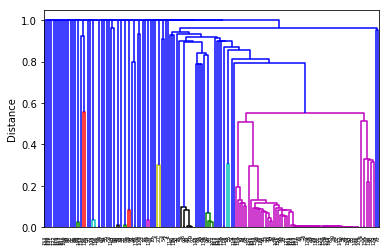

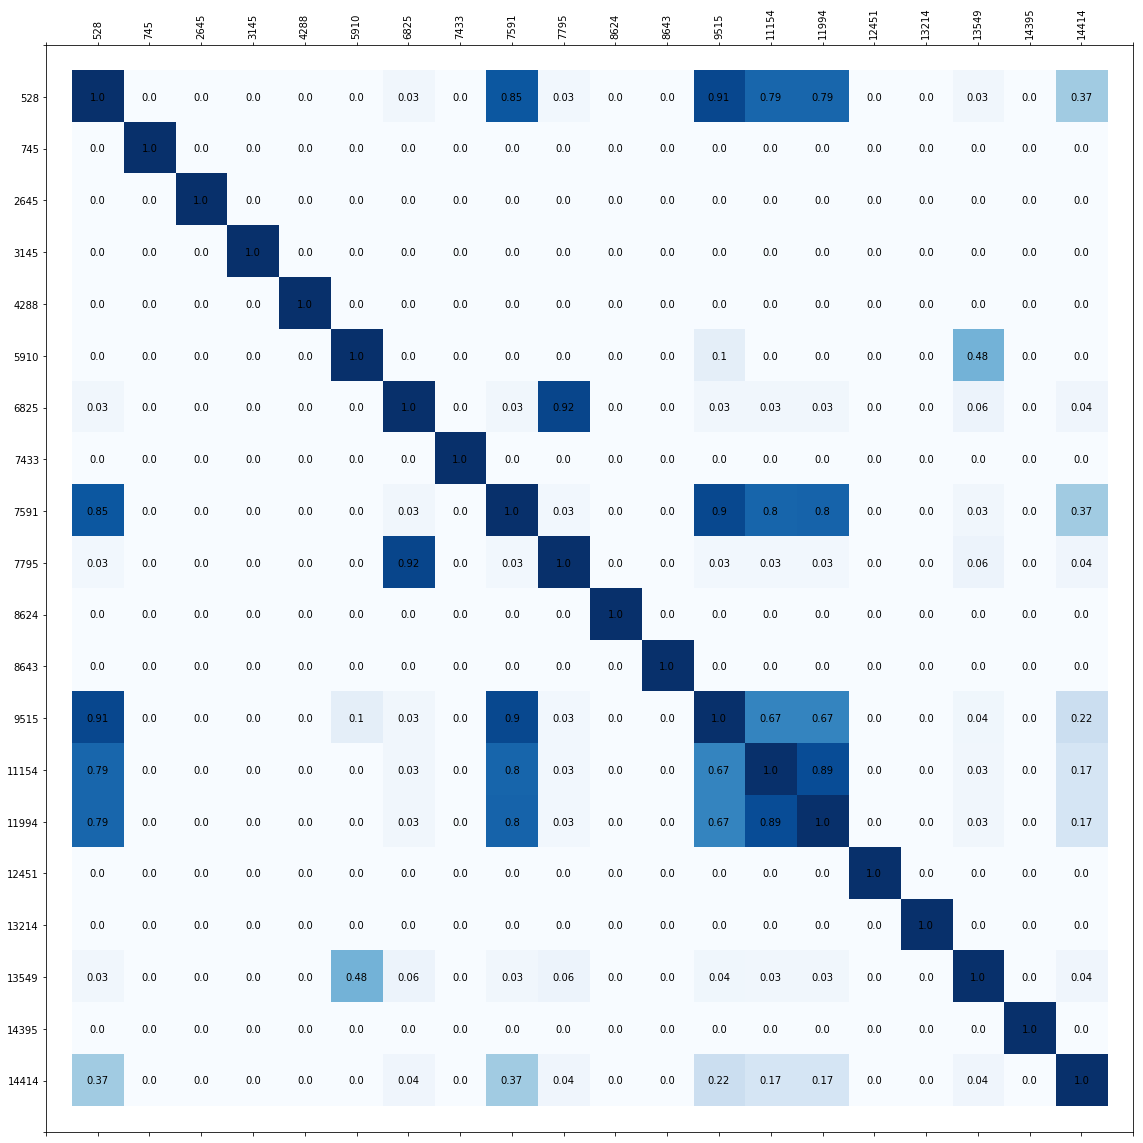

In [38]:
article_dict_subset = dict_by_ids(article_df, good_ids)
jsm = ac.jac_score_mat(article_dict_subset)
hc = ac.cluster_articles(plot = True)
print(ac.prop_unique_clusters())
# ac.display_mat(jsm, xlabs = list(article_dict.keys()))
n_subset = 20
ac.display_mat(subsetmat(jsm, list(range(n_subset))), xlabs = list(article_dict_subset.keys())[0:n_subset])

Good articles: 1703 True 6393 True
S 9 : Updated: June 1, 2019 @ 8:22 pm 
 419-636-1111 | news@bryantimes.com | 127 S. Walnut St., Bryan, OH 43506 
 Toggle navigation 
 DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): 
 6:25 p.m. 
 Josef Newgarden has won the first of two Detroit Grand Prix races, outlasting the competition Saturday on a rain-slicked road course. 

	T 1 0.54 : (AP Photo/Carlos Osorio) 
 DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): 
 6:25 p.m. 
 Josef Newgarden has won the first of two Detroit Grand Prix races, outlasting the competition Saturday on a rain-slicked road course. 

S 10 : The Team Penske driver finished nearly a second in front of Alexander Rossi, who also was the runner-up at the Indianapolis 500, and Takuma Sato. 

	T 2 1.0 : The Team Penske driver finished nearly a second in front of Alexander Rossi, who also was the runner-up at the Indianapolis 500, and Takuma Sato. 

S 11 : Newgarden, who opened the yea

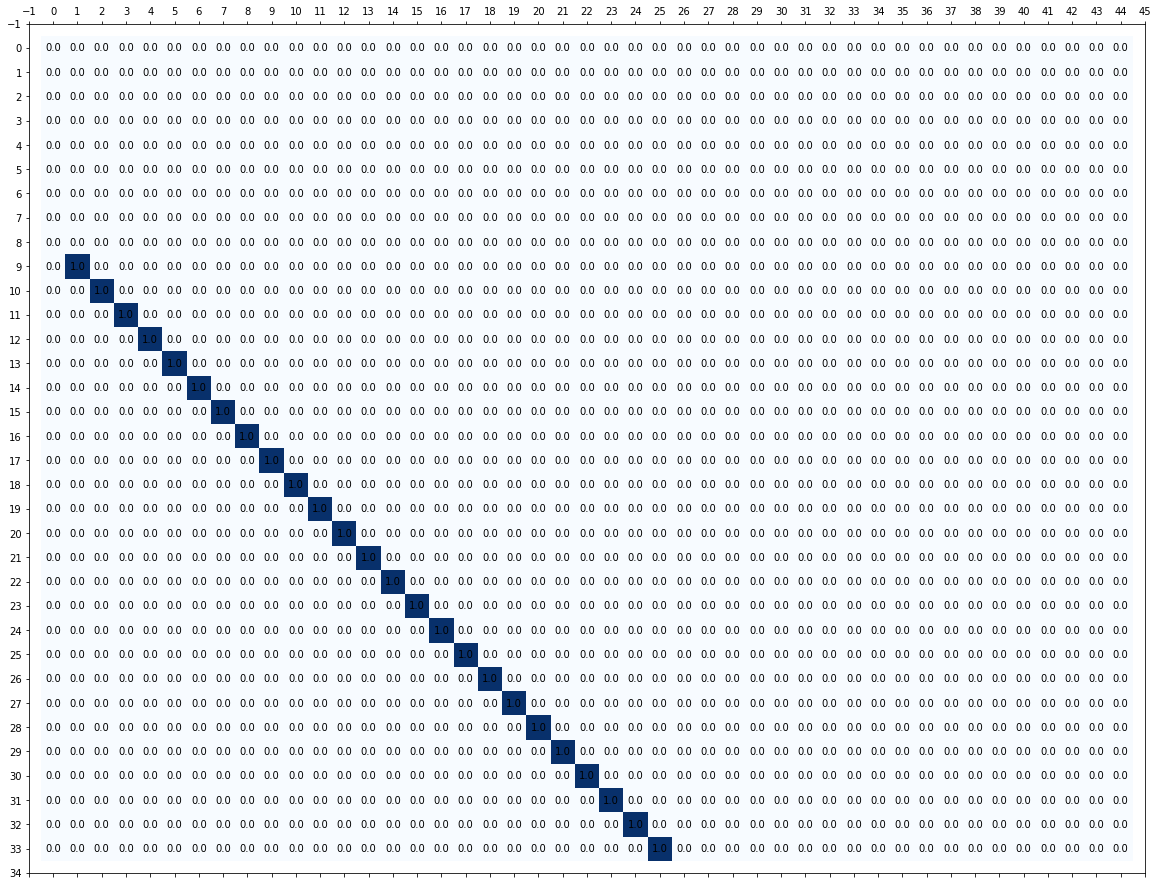

In [7]:
id1 = 1703
id2 = 6393
print("Good articles: %d" % id1, id1 in good_ids, id2, id2 in good_ids)
ac.display_mat(ac.get_match_matrix(article_dict[id1], article_dict[id2]))
ac.print_sentence_matches()

In [8]:
print(article_dict[id1])

Thank you for Reading! 
 Please log in, or sign up for a new account and purchase a subscription to continue reading. 
 (43506) 
 Today 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%.. 
 Tonight 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%. 
 Updated: June 1, 2019 @ 8:22 pm 
 (43506) 
 Today 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%.. 
 Tonight 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%. 
 Updated: June 1, 2019 @ 8:22 pm 
 419-636-1111 | news@bryantimes.com | 127 S. Walnut St., Bryan, OH 43506 
 Toggle navigation 
 DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): 
 6:25 p.m. 
 Josef Newgarden has won the